# EE 379K Lab 5

## Rohan Nagar and Wenyang Fu

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Problem 1: LDA

### Part 1

Generate 20 random points in $d = 3$, from a Gaussian multivariate distribution with mean $[0, 0, 0]$ and covariance matrix $[[1, 0.9, 0.9], [0.9, 1, 0.9], [0.9, 0.9, 1]]$. Call this data with label 1. Also generate 20 random points in $d = 3$ from another Gaussian with mean $[0, 0, 1]$ and covariance $[[1, 0.8, 0.8], [0.8, 1, 0.8], [0.8, 0.8, 1]]$. Call that data with label 2. Create a three dimensional plot of the clouds of data points, labeled with the two labels.

/Users/rohannagar/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


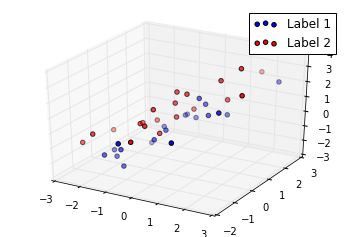

In [6]:
# Covariance matrices
cov1 = [[1, 0.9, 0.9],
        [0.9, 1, 0.9],
        [0.9, 0.9, 1]]
cov2 = [[1, 0.8, 0.8],
        [0.8, 1, 0.8],
        [0.8, 0.8, 1]]

# Generate the samples
label1_samples = np.random.multivariate_normal([0, 0, 0], cov1, 20)
label2_samples = np.random.multivariate_normal([0, 0, 1], cov2, 20)

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(label1_samples.T[0], label1_samples.T[1], label1_samples.T[2], label='Label 1')
ax.scatter(label2_samples.T[0], label2_samples.T[1], label2_samples.T[2], c='r', label='Label 2')
ax.legend()
fig.show()

### Part 2

Perform a projection of the data on one dimension using Fischer's Linear Discriminant as explained in class (see also http://research.cs.tamu.edu/prism/lectures/pr/pr_l10.pdf). No sklearn LDA functions here, just friendly linear algebra.

### Part 3

Use $\tt{sklearn}$ to perform Linear Discriminant Analysis. Compare the results.

# Problem 2: More Kaggle

### Part 1

Goal: Get the best score you can in the Housing prices competition. https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

### Part 2

Train a ridge regression and a lasso regression model. Optimize the alphas using cross validation. What is the best score you can get from a single ridge regression model and from a single lasso model?

### Part 3

Plot the $l_0$ norm (number of nonzeros) of the coefficients that lasso produces as you vary alpha.

### Part 4

Add the outputs of your models as features and train a ridge regression on all the features plus the model outputs (this is called ensembling and stacking). Be careful not to overfit. What score can you get?

### Part 5

Install XGBoost and train a gradient boosting regression. What score can you get just from a single XGB? (you will need to optimize over its parameters).

### Part 6

Do your best to win. Try feature engineering and stacking many models. You are allowed to use any public tool in Python. No nonpython tools allowed.

### Part 7

Read (and post) in the Kaggle forums. Include in your report if you find something in the forums that you like, or if you made a post or code, especially if other Kagglers used it afterwards.

### Part 8

Be sure you do not violate the rules of Kaggle! No sharing of code or data outside of the Kaggle forums. Every student should have their own individual Kaggle account and teams can be formed in the Kaggle submissions with your lab partner.

### Part 9

You will be graded based on your public score (include that in your report) and also on the creativity of your solution. In your report, explain what worked and what did not work. Many creative things will not work, but you will get partial credit for developing them. We will invite teams with interesting solutions to present them in class.